# TAOS2 campaign: clean ctd data

- taos2-drifters0 not processed

(- no ctd collected during taos1-drifters1)

In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import cmocean.cm as cm

import numpy as np
import pandas as pd
import xarray as xr

#
import pynsitu as pin
from pynsitu.maps import crs
import taos.sensors as se

In [2]:
## taos
root_dir = "/Users/aponte/Current_Projects/taos/campagnes/taos2/"

# taos1-drifters0
campaign="taos2_drifters0"
yaml = f"drifters0/{campaign}.yaml"

# taos0-drifters1
#campaign="taos0_drifters1"
#yaml = f"drifters1/{campaign}.yaml"

cp = pin.Campaign(os.path.join(root_dir,yaml))

# plot all deployments
for label, deployment, platform, sensor, meta in cp.get_all_deployments():
    print(label, platform, sensor, deployment)

d0 drifter0 None d0 / start 2023-05-05 08:17:00 -0.25 49.34 / end 2023-05-09 12:38:00 -0.08 49.69
d0 drifter1 None d0 / start 2023-05-05 08:22:18 -0.26 49.34 / end 2023-05-09 11:56:40 -0.23 49.67
d0 drifter2 None d0 / start 2023-05-05 08:31:58 -0.27 49.33 / end 2023-05-11 12:33:12 0.05 49.65
d0 drifter3 None d0 / start 2023-05-05 08:36:48 -0.27 49.34 / end 2023-05-09 10:30:13 -0.20 49.63
d0 drifter4 None d0 / start 2023-05-05 08:45:38 -0.26 49.34 / end 2023-05-09 12:36:09 -0.26 49.67
d0 drifter5 None d0 / start 2023-05-05 08:47:30 -0.25 49.34 / end 2023-05-09 12:08:44 -0.18 49.68
d0 drifter6 None d0 / start 2023-05-05 08:54:20 -0.24 49.35 / end 2023-05-11 12:00:23 -0.28 49.68
d0 drifter7 None d0 / start 2023-05-05 09:01:08 -0.24 49.35 / end 2023-05-09 11:41:20 -0.23 49.67
d0 drifter8 None d0 / start 2023-05-05 09:06:51 -0.25 49.35 / end 2023-05-11 11:54:13 -0.23 49.65
d0 drifter9 None d0 / start 2023-05-05 09:10:52 -0.26 49.35 / end 2023-05-09 10:34:24 -0.19 49.62
d0 hydrophone None d0

---

## ctd, underway, cast

Very convenient the GPS logging !

**taos2 - drifters0**

- Hydrophone: ??

**taos2 - drifters1**

- ??
   
Keep only downcast (because slower than upcast and sensors are facing down) for CTD profiles

Salinity is discretized at 0.01, which turns out to be often less than the top to bottom difference.


In [3]:
#p, s, stype = "delphy", "ctd", 0 # frank
p, s, stype = "hydrophone", "ctd", 1 # benji
tz_offset=-1
despike=False

#d_label, label = "c1", "cast1"
d_label, label = "s0", "d0"
#d_label, label = "c0", "d1"
ctd_path = os.path.join(cp["path_raw"], f"ctd_{p}_{label}.csv")

if "file" in cp[p][s][d_label]:
    ctd_path = os.path.join(cp["path_raw"], cp[p][s][d_label]["file"])

ctd_path

'/Users/aponte/Current_projects/taos/campagnes/taos2/drifters0/raw/ctd_hydrophone_d0.csv'

In [ ]:
df = se.read_lern_sonde(ctd_path, tz_offset=tz_offset, stype=stype)
print(f" processing "+ctd_path)

# rule=None -> raw data
df.sw.plot_bokeh(deployments=cp[p][s][d_label], cross=False)

### plot raw salinity and diff to identify spikes

May be skipped if data is known not to have noisy salinity

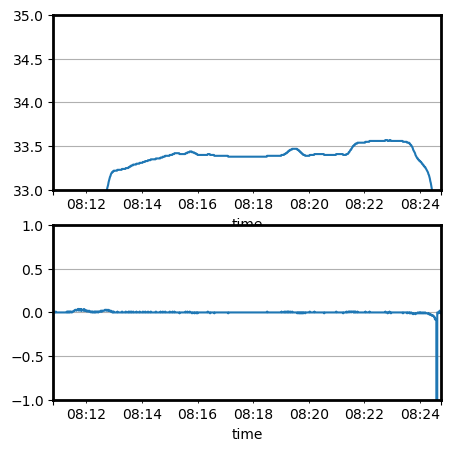

In [5]:
def plot_salinity(df, **kwargs):

    fig, axes = plt.subplots(2,1, figsize=(5,5))
    ax = axes[0]
    df.salinity.plot(ax=ax, **kwargs)
    ax.grid()
    ax.set_ylim([33,35])

    ax = axes[1]
    df.salinity.diff().plot(ax=ax, **kwargs)
    ax.grid()
    ax.set_ylim([-1,1])

plot_salinity(df)

fractions of salinity difference (with smoothed salinity) lower than 0.2 psu = 98.9%


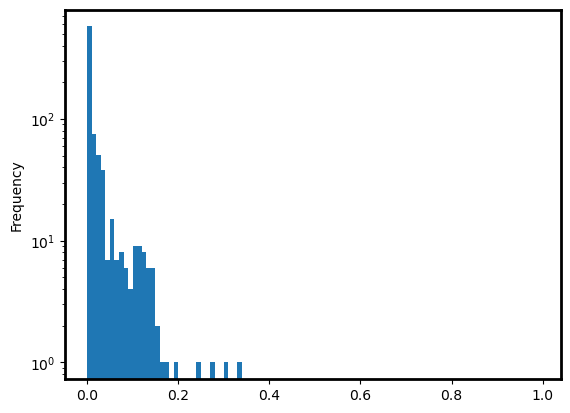

In [6]:
# salinity smoothing
rule = "10s" # 20s at 2m/s is 40m
dsalinity_threshold = 0.2

fig, ax = plt.subplots(1,1)
dfs = df.rolling(window=rule).median()
ds = df.salinity-dfs.salinity
np.abs(ds).plot.hist(bins=np.arange(0,1,.01), ax=ax)
ax.set_yscale("log")

_frac = (ds.loc[np.abs(ds)<dsalinity_threshold].index.size / ds.index.size)
print(f"fractions of salinity difference (with smoothed salinity) lower than {dsalinity_threshold} psu = {_frac*100:.1f}%")

### plot one cast time series

Search to highlight casts quality

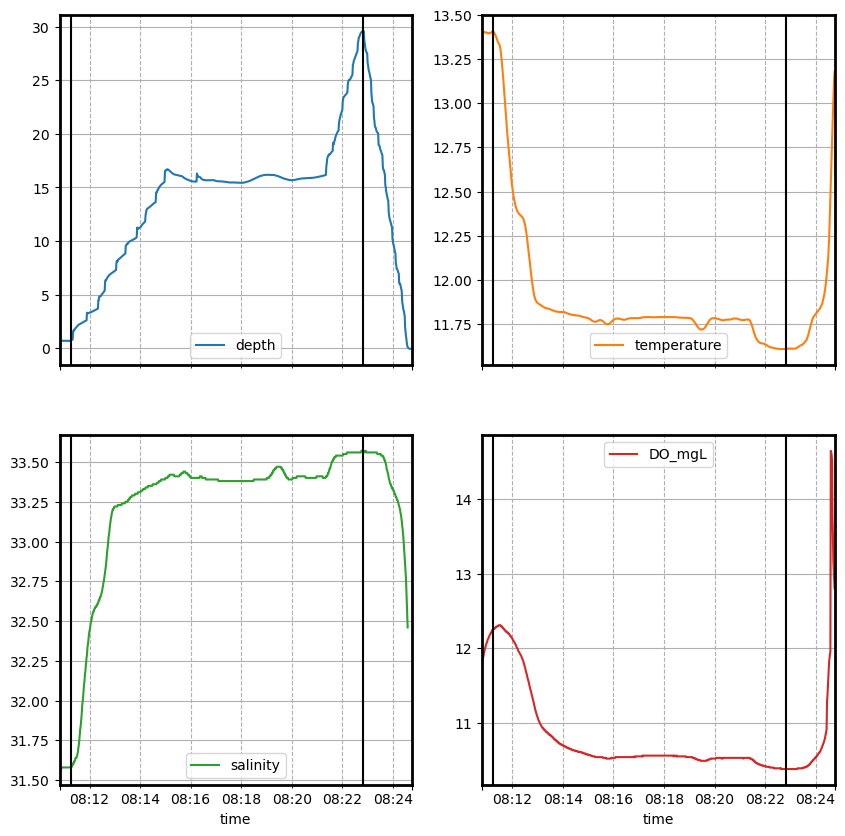

In [7]:
#_df = df.loc["2022-05-17 08:50:00":"2022-05-17 08:55:00"]
#_df = df.loc[d.start.time:d.end.time]
_df = df.copy()
d = cp[p][s][d_label]

_df = _df.loc[:,["depth", "temperature", "salinity", "DO_mgL"]]
_df["salinity"] = _df["salinity"].where(_df["salinity"]>30)

axes = _df.plot(subplots=True, figsize=(10,10), grid=True, layout=(2,2))
for ax in axes.flatten():
    ax.grid(which='minor', axis='both', linestyle='--')
    ax.axvline(d.start.time, color="k")
    ax.axvline(d.end.time, color="k")

---

## trim, filter and store: multiple files

In [9]:
# transect parameters
ds = 20. # m, horizontal spacing - underway
vmin = 0.5 # m/s, tune search parameter - underway
dz = 0.5 # m, vertical spacing - cast

s_vars = ["salinity", "conductivity", "SA"]

if p=="delphy":
    # delphy
    labels = None
elif p=="hydrophone":
    # hydrophone: need to be run twice
    #labels = [f"s{i}" for i in range(9)]
    #ctd_path = os.path.join(cp["path_raw"], f"ctd_{p}_d0.csv")
    #
    labels = [f"c{i}" for i in range(8)]
    ctd_path = os.path.join(cp["path_raw"], f"ctd_{p}_d1.csv")

D = {}
for label, d in cp[p][s].items():
    if labels is not None and label not in labels:
        continue
    if "file" in d:
        ctd_path = os.path.join(cp["path_raw"], d["file"])
    df = se.read_lern_sonde(ctd_path, tz_offset=tz_offset, stype=stype)    
    # fix position for taos2-drifters0, hydrophone data
    if campaign=="taos2_drifters0" and p=="hydrophone":
        # should concatenate in general below
        hy = cp.load("hydrophone_d0.nc")
        hy_interpolated = hy.interp(time=df.index)
        df["longitude"] = hy_interpolated["longitude"].values
        df["latitude"] = hy_interpolated["latitude"].values
    # trim first to exclude irrelevant values
    _df = df.ts.trim(d)
    if d.label[0]=="u":
        # underway data
        print(d, "underway processing")
        ## simple temporal average
        #_df = _df.sw.resample("20s", op="median")
        ## despike salinity
        if despike:
            #_df = _df.loc[ np.abs(_df.salinity.diff())<0.1 ]
            _dfs = _df.rolling(window=rule).median() 
            _ds = _df.salinity - _dfs.salinity
            _df.loc[np.abs(_ds) > dsalinity_threshold, s_vars] = np.NaN
            # interpolate gaps
            _df.loc[:, s_vars] = _df.loc[:, s_vars].interpolate(method="linear")
        ## interpolate on a regularly sampled transect
        _df = _df.geo.compute_transect(ds, vmin=vmin)
        # update temperature, salinity and sigma0 from PA, CT
        _df.sw.update_eos()
    if d.label[0]=="s":
        # underway data
        print(d, "surface point processing")
        ## despike salinity
        if despike:
            #_df = _df.loc[ np.abs(_df.salinity.diff())<0.1 ]
            _dfs = _df.rolling(window=rule).median() 
            _ds = _df.salinity - _dfs.salinity
            _df.loc[np.abs(_ds) > dsalinity_threshold, s_vars] = np.NaN
            # interpolate gaps
            _df.loc[:, s_vars] = _df.loc[:, s_vars].interpolate(method="linear")
        ## simple temporal smoothing
        _df = _df.sw.resample("20s", op="mean")
        # update temperature, salinity and sigma0 from PA, CT
        _df.sw.update_eos()
    elif d.label[0]=="c":
        print(d, "cast processing")
        # if no longitude/latitude fills with cp information
        if all(pd.isna(_df["latitude"])) or all(pd.isna(_df["latitude"])):
            print("no values of lon/lat, fills in with cp")
            _df["latitude"]=d.start.lat
            _df["longitude"]=d.start.lon
        _df = _df.sw.compute_vertical_profile(dz)
    D[d.label] = _df

c0 / start 2023-05-05 09:22:19 / end 2023-05-05 09:23:35 cast processing
some values of longitude and latitudes are NaN, you may want to fill in with correct values
some values of longitude and latitudes are NaN, you may want to fill in with correct values
c1 / start 2023-05-05 09:41:58 / end 2023-05-05 09:43:50 cast processing
some values of longitude and latitudes are NaN, you may want to fill in with correct values
some values of longitude and latitudes are NaN, you may want to fill in with correct values
c2 / start 2023-05-05 09:53:14 / end 2023-05-05 09:54:58 cast processing
some values of longitude and latitudes are NaN, you may want to fill in with correct values
some values of longitude and latitudes are NaN, you may want to fill in with correct values
c3 / start 2023-05-05 10:02:41 / end 2023-05-05 10:04:43 cast processing
some values of longitude and latitudes are NaN, you may want to fill in with correct values
some values of longitude and latitudes are NaN, you may want to 

### store

In [10]:
for d, _df in D.items():
    if labels is not None and d not in labels:
        continue
    _df.to_xarray().to_netcdf(os.path.join(cp["path_processed"], f'{s}_{p}_{d}.nc'), mode="w")